In [1]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sindhujadid184","key":"426f94110db5b9fae80ad74948704e65"}'}

In [2]:

!pip install kaggle --upgrade
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json



In [3]:
!kaggle datasets download -d adityajn105/flickr8k
!unzip -q flickr8k.zip -d flickr8k


Dataset URL: https://www.kaggle.com/datasets/adityajn105/flickr8k
License(s): CC0-1.0
 99% 1.03G/1.04G [00:06<00:00, 251MB/s]
100% 1.04G/1.04G [00:06<00:00, 177MB/s]


In [25]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

## Extracting Image Features

In [79]:
model = VGG16()
model = Model(inputs=model.input, outputs=model.layers[-2].output)


print(model.summary())


553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:

# Extractfeatures from images
features = {}

directory = '/content/flickr8k/Images'

for img_name in tqdm(os.listdir(directory)):
  #Load Image from file
  img_path = directory + '/' + img_name

  image = load_img(img_path, target_size = (224, 224))
  image = img_to_array(image)

  image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))

  image = preprocess_input(image)

  feature = model.predict(image, verbose=0)

  image_id = img_name.split('.')[0]

  features[image_id] = feature


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


## Loading Features


In [6]:
## LOad Features
import pickle
import os
store_at = '/content/drive/MyDrive/image-caption-gen/'
with open(os.path.join(store_at, "features.pkl"), "rb") as f:
  features = pickle.load(f)


### Load Captions

In [14]:
from tqdm import tqdm
cap_place = '/content/flickr8k/captions.txt'

with open(cap_place, 'r') as f:
  ## First line has cap
  next(f)
  captions_doc = f.read()


In [15]:
mapping = {}

for line in tqdm(captions_doc.split('\n')):
    tokens = line.strip().split(',')

    if len(tokens) < 2:
        continue

    image_id, caption = tokens[0], tokens[1:]
    image_id = image_id.split('.')[0]
    caption = " ".join(caption)

    if image_id not in mapping:
        mapping[image_id] = []

    mapping[image_id].append(caption)


100%|██████████| 40456/40456 [00:00<00:00, 384015.12it/s]


In [18]:
import re

def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            caption = captions[i]

            # Convert to lowercase
            caption = caption.lower()

            # Remove special characters and digits using regex
            caption = re.sub(r'[^a-z\s]', '', caption)

            # Remove single-character words and extra whitespace
            caption = ' '.join([word for word in caption.split() if len(word) > 1])

            # Add start and end tokens
            caption = 'startseq ' + caption.strip() + ' endseq'

            # Update the list
            captions[i] = caption


In [19]:
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [20]:
clean(mapping)

In [21]:

mapping['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [22]:
all_captions = []

for key in mapping:
  for caption in mapping[key]:
    all_captions.append(caption)

In [23]:
all_captions[:5]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [26]:
#Tokenize The Text
tokenizer = Tokenizer()

tokenizer.fit_on_texts(all_captions)

vocab_size = len(tokenizer.word_index) + 1

vocab_size


8768

In [30]:
#Get maxlength
max_length = max(len(caption.split()) for caption in all_captions)

max_length

34

### Splitting

In [31]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
split

7281

In [32]:
train = image_ids[:split]
test = image_ids[split:]


# Model Creation

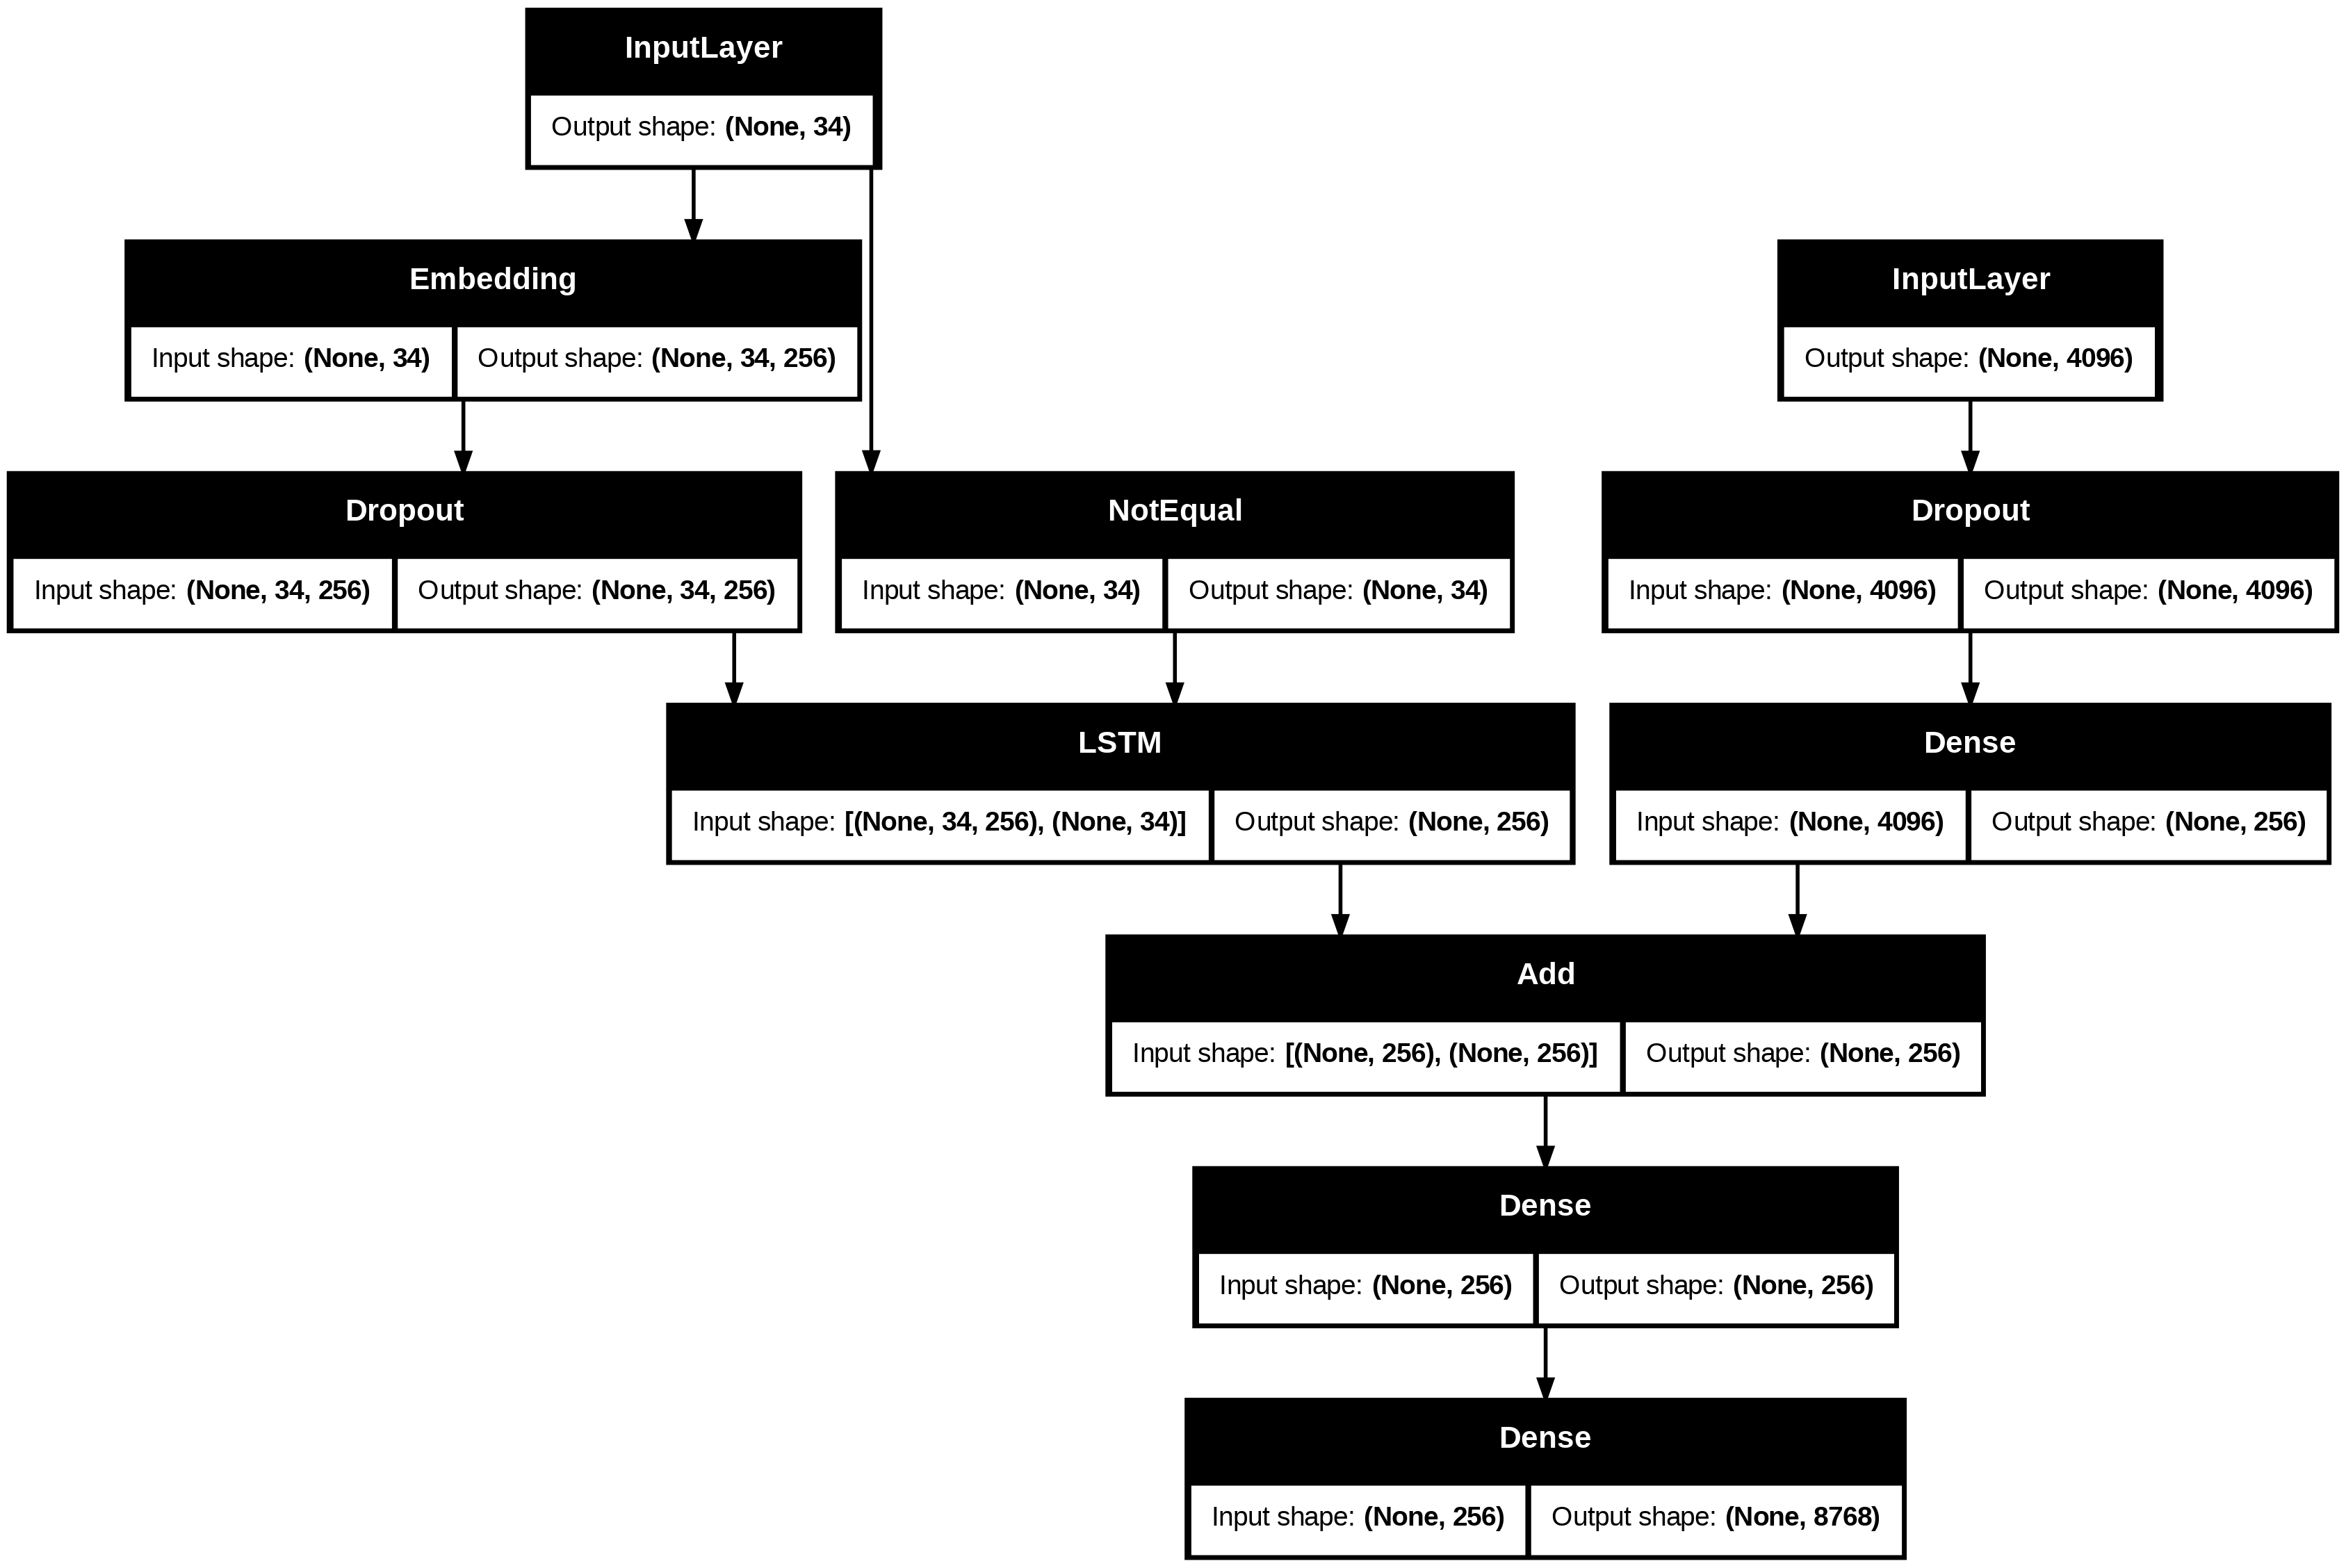

In [34]:
#Encoder Model
#Image Feature layer
import tensorflow as tf
inputs1 = Input(shape = (4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation = 'relu')(fe1)

# Sequence Model
inputs2 = Input(shape = (max_length,))
se1 = Embedding(vocab_size, 256, mask_zero = True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

#Decoder Model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation = 'relu')(decoder1)
outputs = Dense(vocab_size, activation = 'softmax')(decoder2)

model = Model(inputs = [inputs1, inputs2], outputs = outputs)
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer='adam'
)
plot_model(model, show_shapes = True)

In [37]:
# def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
#   #Image Features, Text, Output
#   X1, X2, y = list(), list(), list()

#   n = 0;

#   while 1:
#     for key in tqdm(data_keys, desc="Generating Batches"):
#       captions = mapping[key]

#       for caption in captions:
#         seq = tokenizer.texts_to_sequences([caption])[0]

#         for i in range(1, len(seq)):
#           in_seq, out_seq = seq[:i], seq[i]

#           in_seq = pad_sequences([in_seq], maxlen = max_length)[0]

#           out_seq = to_categorical([out_seq], num_classes = vocab_size)[0]


#           X1.append(features[key][0])
#           X2.append(in_seq)
#           y.append(out_seq)
#           n += 1
#         if n == batch_size:
#           X1, X2, y = np.array(X1), np.array(X2), np.array(y)
#           yield [X1, X2], y

#           X1, X2, y = list(), list(), list()
#           n = 0
output_signature = (
    (
        tf.TensorSpec(shape=(None, 4096), dtype=tf.float32),  # VGG16 fc2 features
        tf.TensorSpec(shape=(None, max_length), dtype=tf.int32)
    ),
    tf.TensorSpec(shape=(None,), dtype=tf.int32)
)

def data_generator(data_keys, mapping, features, tokenizer, max_length, batch_size):
    X1, X2, y = [], [], []
    n = 0

    while True:
        for key in tqdm(data_keys, desc="Generating Batches"):
            captions = mapping.get(key, [])

            for caption in captions:
                seq = tokenizer.texts_to_sequences([caption])[0]

                for i in range(1, len(seq)):
                    in_seq = seq[:i]
                    out_seq = seq[i]

                    # Right padding to avoid cuDNN masking errors
                    in_seq = pad_sequences([in_seq], maxlen=max_length, padding='post')[0]

                    X1.append(features[key][0])  # Pre-extracted image feature vector (4096-d)
                    X2.append(in_seq)
                    y.append(out_seq)

                    n += 1
                    if n == batch_size:
                        yield (np.array(X1, dtype=np.float32),
                               np.array(X2, dtype=np.int32)), \
                              np.array(y, dtype=np.int32)
                        X1, X2, y = [], [], []
                        n = 0


In [40]:
epochs = 15
batch_size = 64
steps = len(train) // batch_size

for i in range(epochs):
    print(f" Epoch {i+1}/{epochs}")

    generator = data_generator(
        train,
        mapping,
        features,
        tokenizer,
        max_length,
        batch_size
    )

    dataset = tf.data.Dataset.from_generator(
      lambda: data_generator(train, mapping, features, tokenizer, max_length, batch_size),
      output_signature=output_signature
  )


    model.fit(
        dataset,
        epochs=1,  # Only 1 epoch per iteration
        steps_per_epoch=steps,
        verbose=1
    )


 Epoch 1/15


Generating Batches:   0%|          | 0/7281 [00:00<?, ?it/s]

113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 3.1667
 Epoch 2/15


Generating Batches:   0%|          | 0/7281 [00:00<?, ?it/s]

113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 2.7856
 Epoch 3/15


Generating Batches:   0%|          | 0/7281 [00:00<?, ?it/s]

113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.5130
 Epoch 4/15


Generating Batches:   0%|          | 0/7281 [00:00<?, ?it/s]

113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.3338
 Epoch 5/15


Generating Batches:   0%|          | 0/7281 [00:00<?, ?it/s]

113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.2099
 Epoch 6/15


Generating Batches:   0%|          | 0/7281 [00:00<?, ?it/s]

113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.1192
 Epoch 7/15


Generating Batches:   0%|          | 0/7281 [00:00<?, ?it/s]

113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.0565
 Epoch 8/15


Generating Batches:   0%|          | 0/7281 [00:00<?, ?it/s]

113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 2.0056
 Epoch 9/15


Generating Batches:   0%|          | 0/7281 [00:00<?, ?it/s]

113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.9661
 Epoch 10/15


Generating Batches:   0%|          | 0/7281 [00:00<?, ?it/s]

113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.9313
 Epoch 11/15


Generating Batches:   0%|          | 0/7281 [00:00<?, ?it/s]

113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.8839
 Epoch 12/15


Generating Batches:   0%|          | 0/7281 [00:00<?, ?it/s]

113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.8666
 Epoch 13/15


Generating Batches:   0%|          | 0/7281 [00:00<?, ?it/s]

113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.8118
 Epoch 14/15


Generating Batches:   0%|          | 0/7281 [00:00<?, ?it/s]

113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.7910
 Epoch 15/15


Generating Batches:   0%|          | 0/7281 [00:00<?, ?it/s]

113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 1.7431


In [39]:
model.weights

[<Variable path=embedding_1/embeddings, shape=(8768, 256), dtype=float32, value=[[-0.0167848   0.02947588  0.0499394  ...  0.01575831 -0.0257008
   -0.03664985]
  [ 0.19007297  0.00050062 -0.11648501 ...  0.12521744  0.08931095
    0.0864657 ]
  [ 0.02022168 -0.04118549  0.00196341 ... -0.04256862  0.00247528
    0.01109866]
  ...
  [ 0.00811564 -0.04840536 -0.01729131 ...  0.04706747 -0.0383157
   -0.04320423]
  [-0.00612106  0.01533834  0.00121261 ...  0.01938417 -0.01826024
   -0.03242119]
  [ 0.04316309  0.03309044  0.02192027 ... -0.00792066  0.03258881
    0.03281761]]>,
 <Variable path=dense_3/kernel, shape=(4096, 256), dtype=float32, value=[[-0.02670165 -0.00904419 -0.03790908 ...  0.01131085 -0.01763453
    0.00681274]
  [-0.05406966 -0.00861964 -0.0218854  ... -0.04062662  0.00511792
    0.01955306]
  [-0.04197926 -0.02996471 -0.04802696 ...  0.02330424  0.01761474
    0.01352765]
  ...
  [-0.03405454  0.00059179  0.01923959 ... -0.00710832 -0.03885687
    0.00260904]
  [ 0.0

In [41]:
model.save('/content/drive/MyDrive/image-caption-gen/best_model.h5')

### GENERATE CAPTIONS FOR THE IMAGE

In [42]:
def idx_to_word(integer, tokenizer):
  for word, index in tokenizer.word_index.items():
    if index == integer:
      return word
  return None

In [54]:
def predict_caption(model, image, tokenizer, max_length):
    in_text = 'startseq'

    for _ in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length, padding='post')

        # Make sure image is shaped (1, 4096)
        image_input = image.reshape((1, 4096))

        yhat = model.predict([image_input, sequence], verbose=0)
        yhat = np.argmax(yhat)

        word = tokenizer.index_word.get(yhat)
        if word is None:
            break

        in_text += ' ' + word
        if word == 'endseq':
            break

    return in_text.replace('startseq', '').replace('endseq', '').strip()


In [55]:
actual = []
predicted = []

for key in tqdm(test, desc="Validating"):
    captions = mapping[key]
    y_pred = predict_caption(model, features[key], tokenizer, max_length)


    actual_captions = [caption.split() for caption in captions]
    predicted_caption = y_pred.split()

    actual.append(actual_captions)
    predicted.append(predicted_caption)


Validating:   0%|          | 0/810 [00:00<?, ?it/s]

In [58]:
from nltk.translate.bleu_score import corpus_bleu

print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights = (1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights = (0.5, 0.5, 0, 0)))

BLEU-1: 0.230803
BLEU-2: 0.121542


### Visualize Results

In [75]:
from PIL import Image
import matplotlib.pyplot as plt

def generate_caption(image_name):
    image_id = image_name.split('.')[0]
    image_path = f"/content/flickr8k/Images/{image_name}"
    image = Image.open(image_path)

    captions = mapping.get(image_id, [])
    print("Actual Captions:")
    for caption in captions:
        print(caption)

    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print("\nPredicted Caption:")
    print(y_pred)

    plt.imshow(image)
    plt.axis('off')
    plt.show()


Actual Captions:
startseq child playing on rope net endseq
startseq little girl climbing on red roping endseq
startseq little girl in pink climbs rope bridge at the park endseq
startseq small child grips onto the red ropes at the playground endseq
startseq the small child climbs on red ropes on playground endseq

Predicted Caption:
little child climbs on the playground


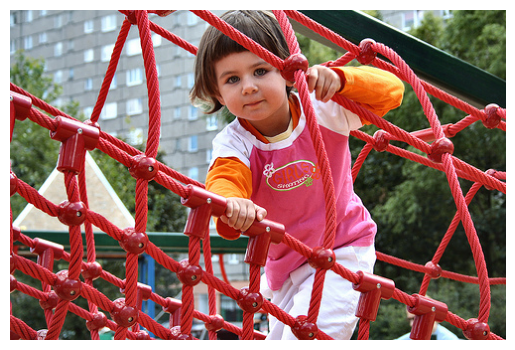

In [76]:
generate_caption('1007320043_627395c3d8.jpg')

Actual Captions:
startseq brown dog plays in deep pile of snow endseq
startseq dog looking at the camera in snow endseq
startseq dog runs through the snow endseq
startseq tan dog stand in the snow and looks up endseq
startseq the brown dog is out in the snow endseq

Predicted Caption:
dog stand out in the the the the the the snow


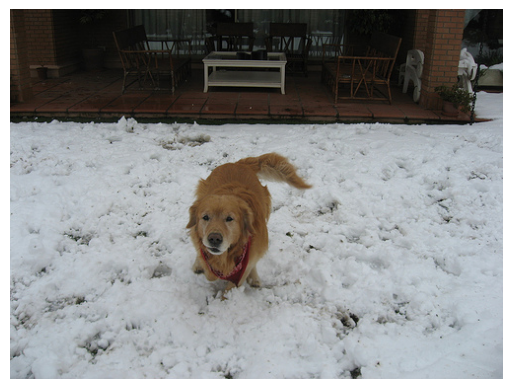

In [78]:
generate_caption('1094462889_f9966dafa6.jpg')